# RSNA_Pneumonia_v001

* v001: Initial Commit

## Imports

https://pydicom.github.io/pydicom/dev/getting_started.html

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import uuid
import pydicom
import glob, pylab
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from os.path import join
print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

['dcm_data.csv', 'stage_1_detailed_class_info.csv', 'stage_1_sample_submission.csv', 'stage_1_train_labels.csv']


## Constants & Functions

Constants

In [3]:
PATH= 'input'#/rsna-pneumonia-detection-challenge/'
path_pics = r'C:\Users\Lorenzo\Downloads\stage_1_train_images'#join(PATH,'stage_1_train_images')

print(os.listdir(path_pics)[:10])

['0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', '00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm', '00322d4d-1c29-4943-afc9-b6754be640eb.dcm', '003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm', '00436515-870c-4b36-a041-de91049b9ab4.dcm', '00569f44-917d-4c86-a842-81832af98c30.dcm', '006cec2e-6ce2-4549-bffa-eadfcd1e9970.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm', '008c19e8-a820-403a-930a-bc74a4053664.dcm', '009482dc-3db5-48d4-8580-5c89c4f01334.dcm']


Functions

In [4]:
class Box():
    
    def __init__(self, y, x, h, w):
        self.y, self.x, self.h, self.w = y, x, h, w

def row2string(row):
    """
    row box to string [y, x, height, width]
    """
    if row is None:
        return ''
    elif math.isnan(row['y']):
        return ''
    else:
        return '{0}_{1}_{2}_{3}'.format(row['y'], row['x'], row['height'], row['width'])
    
def string2boxes(s):
    """
    strings to boxes [y, x, height, width]
    """
    if s == None:
        raise ArgumentException()
    elif s == '' or s == '#':
        return None
    
    boxes = []
    ss = s.split('#')
    for r in ss:
        rr = r.split('_')
        try:
            box = Box(float(rr[0]), float(rr[1]), float(rr[2]), float(rr[3]))
            boxes.append(box)
        except:
            continue
        
    return boxes

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 
    """
    name_pic = data['patientId'] + '.dcm'
    fullpath_pic = join(path_pics, name_pic)

    # --- Open DICOM file
    d = pydicom.read_file(fullpath_pic)
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    boxes = string2boxes(data['boxes'])
    
    # print data
    print(d)
    
    if(boxes != None):
        for box in boxes:
#             rgb = np.floor(np.random.rand(3) * 256).astype('int')
            im = overlay_box(im=im, box=box, rgb=[255, 0, 0], stroke=6)

    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap=pylab.cm.gist_gray)

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image
    """
    
    # --- Extract coordinates
    y1, x1, height, width = int(box.y), int(box.x), int(box.h), int(box.w)
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [5]:
train_label = pd.read_csv(join(PATH,'stage_1_train_labels.csv'))
detailed_class = pd.read_csv(join(PATH,'stage_1_detailed_class_info.csv'))

In [6]:
train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28989 entries, 0 to 28988
Data columns (total 6 columns):
patientId    28989 non-null object
x            8964 non-null float64
y            8964 non-null float64
width        8964 non-null float64
height       8964 non-null float64
Target       28989 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.3+ MB


Build complete DataFrame
* Make a single string out of all the boxes relative to a single patient
* Add pic's properties to df

In [7]:
df = pd.merge(train_label, detailed_class, on='patientId')
df = pd.concat([df, pd.get_dummies(df['class'])], axis=1)

Execute the following code if generating the db

In [8]:
name_pic = pd.read_csv(join(PATH,'dcm_data.csv'), index_col=0)
name_pic['Age'] = name_pic['Age'].astype(int)
name_pic.head()

Age Sex View Position boxes                             patientId
0   51   F            PA     #  0004cfab-14fd-4e49-80ba-63a80b6bddd6
1   48   F            PA     #  00313ee0-9eaa-42f4-b0ab-c148ed3241cd
2   19   M            AP     #  00322d4d-1c29-4943-afc9-b6754be640eb
3   28   M            PA     #  003d8fa0-6bf1-40ed-b54c-ac657f8495c5
4   32   F            AP   NaN  00436515-870c-4b36-a041-de91049b9ab4

In [9]:
df = pd.concat([df, name_pic.drop('patientId', axis=1)], axis=1)
df = df.drop(['x', 'y', 'width', 'height'], axis=1)
df = df.dropna(axis=0, subset=['boxes'])
df.head()

patientId  Target                         class  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       0  No Lung Opacity / Not Normal   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd       0  No Lung Opacity / Not Normal   
2  00322d4d-1c29-4943-afc9-b6754be640eb       0  No Lung Opacity / Not Normal   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5       0                        Normal   
7  00436515-870c-4b36-a041-de91049b9ab4       1                  Lung Opacity   

   Lung Opacity  No Lung Opacity / Not Normal  Normal  Age Sex View Position  \
0             0                             1       0   51   F            PA   
1             0                             1       0   48   F            PA   
2             0                             1       0   19   M            AP   
3             0                             0       1   28   M            PA   
7             1                             0       0   32   F            AP   

                                               boxes  
0                                                  #  
1                                                  #  
2                                                  #  
3                                                  #  
7  #152.0_264.0_379.0_213.0#152.0_264.0_379.0_213...

In [10]:
len(df['patientId']) == len( set(df['patientId']))

True

In [19]:
gna = df[df['No Lung Opacity / Not Normal'] == 1]
print(gna[gna['boxes'] != '#'])

Empty DataFrame
Columns: [patientId, Target, class, Lung Opacity, No Lung Opacity / Not Normal, Normal, Age, Sex, View Position, boxes]
Index: []

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.21004.1517874431.100900
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '00c0b293-48e7-4e16-ac76-9269ba535a62'
(0010, 0020) Patient ID                          LO: '00c0b293-48e7-4e16-ac76-9269ba535a62'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

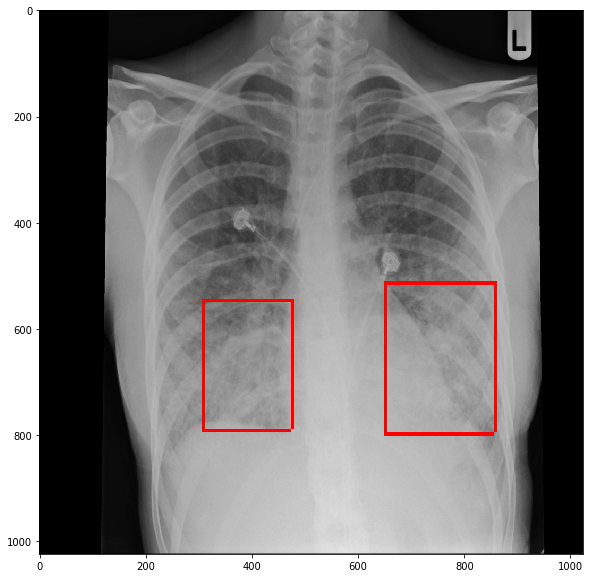

In [11]:
draw(df.iloc[13])

## Analysis

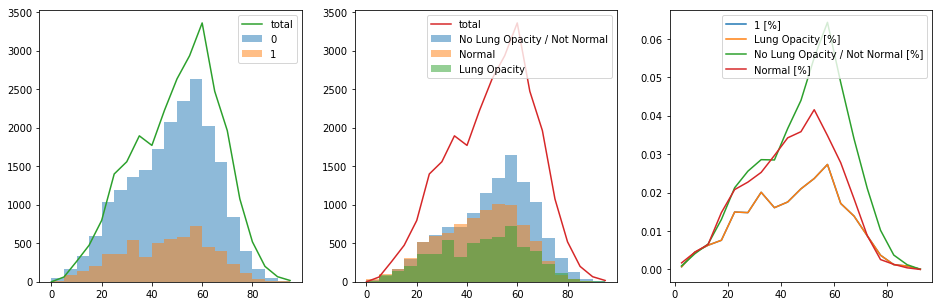

In [12]:
bins = range(0,100,5)
plt.figure(figsize=(16,5))

#plt.figure(1)
plt.subplot(1,3,1)
age_1 = df[['Age', 'Target']][df['Target'] ==1]
age_0 = df[['Age', 'Target']][df['Target'] ==0]

a, _, _ = plt.hist(age_0.sort_values('Age')['Age'], bins, alpha=0.5, label='0')
b, _, _ = plt.hist(age_1.sort_values('Age')['Age'], bins, alpha=0.5, label='1')
plt.plot(range(0,100,5),[0]+[a+b for a,b in zip(*[a,b])], label='total')
plt.legend()


plt.subplot(1,3,2)
lung_opac = df[['Age', 'Target']][df['Lung Opacity'] ==1]
lung_boh = df[['Age', 'Target']][df['No Lung Opacity / Not Normal'] ==1] 
lung_norm = df[['Age', 'Target']][df['Normal'] ==1]

a, _, _ = plt.hist(lung_boh.sort_values('Age')['Age'], bins, alpha=0.5, label='No Lung Opacity / Not Normal')
b, _, _ = plt.hist(lung_norm.sort_values('Age')['Age'], bins, alpha=0.5, label='Normal')
c, _, _ = plt.hist(lung_opac.sort_values('Age')['Age'], bins, alpha=0.5, label='Lung Opacity')
plt.plot(range(0,100,5),[0]+[a+b+c for a,b,c in zip(*[a,b,c])], label='total')
plt.legend()


plt.subplot(1,3,3)
g = pd.cut(df.sort_values('Age')['Age'], bins)
g = df.groupby(g, sort=False)
g_t = g['Target'].aggregate('sum') / len(df)
g_opac = g['Lung Opacity'].aggregate('sum') / len(df)
g_boh = g['No Lung Opacity / Not Normal'].aggregate('sum') / len(df)
g_norm = g['Normal'].aggregate('sum') / len(df)

plt.plot([x.mid for x in g_t.index], g_t, label='1 [%]')
plt.plot([x.mid for x in g_t.index], g_opac, label='Lung Opacity [%]')
plt.plot([x.mid for x in g_t.index], g_boh , label='No Lung Opacity / Not Normal [%]')
plt.plot([x.mid for x in g_t.index], g_norm, label='Normal [%]')
#plt.plot([(a,b) for a,b in zip(*[g_norm.values, g_boh.values])])

plt.legend()
plt.show()

## Correlations

In [14]:
age_sorted = df.sort_values(by='Age').groupby(by='Age')

pd.cut(age_sorted, bins)

patientId  Target  \
10419  5bd1b4bb-924d-485a-8e33-80109e911335       0   
27130  c241425c-418c-4958-8a18-c3425fe03f03       1   
24086  b35d57ee-f22b-4c8c-b959-3ee8eecef555       1   
17127  8968d121-af83-4ac8-a4fe-5e24fcb09ace       0   
33063  ecb0e8b7-0f0f-40ed-848d-8b070a14bc8c       0   
13001  6e94ef7a-a4c1-46b5-8fed-efe23d8ad9e6       0   
4196   35621d68-0915-463c-b0f8-2365c6e56e11       0   
18962  94acade9-f3b8-4b53-860f-e91bb9c33986       0   
31378  e09b8f66-8a1f-4c0f-8c37-22e8bd0dd2f9       0   
19286  9746c15f-94d1-4528-aff0-8ef02ccccef0       0   
115    01fa0f5e-00c3-41cb-b5c7-10600c8633ae       1   
5083   39709c3d-8105-442a-bf70-22a4319b1f47       1   
28308  c9b0cbc7-e448-4531-91e5-6d3e982e5eab       0   
22805  ad89c9de-3e31-4bc8-b8d3-757a76d64af3       0   
3819   33dbca25-e1c9-4bcf-a8a7-4fa716e8a53a       0   
152    02c2331d-b3fa-4d55-bf86-f0efbd589c86       0   
23955  b2d5a048-01c8-4140-9f32-822db6e813c5       1   
8483   4dca2422-fef2-491f-a80f-9cc90838f178       0   
31251  dfbf2061-27d4-452f-80a3-79af6cb529f2       0   
2016   1643d9ee-7f12-4a05-9328-f7d775f6cd2c       0   
2949   2aae181e-a4b7-47f4-ac47-e99001b9008b       1   
3452   3246006e-f323-43c9-a322-4979fdb85f37       1   
25621  ba221090-4382-4ccf-afc2-cda9af445aa5       1   
18064  8eff11d0-2aa4-4033-8e25-3956bc0568b1       0   
32789  eb2225b3-b09e-408c-8c48-27b1bad103a9       1   
33777  f1a6ae49-8a55-4fc9-886c-4bfb6be0d8e2       0   
13227  7013a598-e32c-45c8-ae47-e75dfeffd918       0   
33893  f25fbd2a-7adc-4701-95c4-549983ce8aa7       0   
32677  ea5cc41a-f379-4d12-ae6c-129149c99c7b       0   
21350  a53a67ff-caf0-442f-b514-260795b6cd3a       0   
...                                     ...     ...   
29646  d346540b-05a3-43f3-9d55-858aaa915c22       0   
34747  f852e922-6bcc-4ef2-851e-7fcc81296ddf       0   
32286  e74ea5c9-54d7-4f2f-a7f8-33199923bb9f       0   
4900   38929efc-a8ad-42b5-9fff-8ba881a7873e       1   
7879   497395af-04b8-4318-ba8f-2e79d99fc2b2       0   
11489  63fe1ae4-bd2d-4777-9dfc-8683aba56460       0   
16761  872dd366-ad94-4bda-b7d3-0e7edf17e237       0   
5325   3a8a880f-c71c-4130-b220-77896771715b       0   
30471  d97e5889-7104-475b-bf38-69b04157515c       0   
7142   4465b85f-2ae5-474f-a649-0ffcbd5ebb75       0   
26427  bda1d8b6-2a74-41c3-8cef-3ff7864e4613       1   
10602  5d3416fb-ca92-4c04-a178-bdaa2c0c87f7       0   
3297   31bef3ba-3580-40ab-a7af-567a5c95e4da       1   
12224  695040a0-f7dd-46b4-8eb5-5dc87290e43b       0   
27352  c3768927-0d7e-4624-bf5a-3eea2011a5c1       1   
3806   33d21874-f7b1-413c-8013-0b4a98d12fb9       1   
11891  66a9c8fb-d33d-4ec8-b8bd-d0c1db96a0c2       0   
18893  94444285-2030-4d81-b6a7-d7c4d5abfa20       0   
15022  7bb1c647-d8d1-4640-b495-f41c4d2a34ca       1   
25250  b8999532-31ea-4659-9039-d83a6fab490c       1   
30614  dab2f334-331c-42c7-af09-a997092464b0       0   
13574  723c952a-b50a-42e1-a0d6-5d177bc635d2       1   
25476  b9a50c1f-4b93-4a91-963f-a8d06fe077ee       1   
31721  e3314152-aa5f-4dff-93f8-93dc0bcbe57b       0   
11105  6108f7c0-96c4-48e6-994e-32e3cbeaf8d7       1   
5525   3b8b8777-a1f6-4384-872a-28b95f59bf0d       0   
32970  ec3697bd-184e-44ba-9688-ff8d5fbf9bbc       0   
13818  73aeea88-fc48-4030-8564-0a9d7fdecac4       0   
21301  a4e8e96d-93a6-4251-b617-91382e610fab       0   
34436  f632328d-5819-4b29-b54f-adf4934bbee6       0   

                              class  Lung Opacity  \
10419  No Lung Opacity / Not Normal             0   
27130                  Lung Opacity             1   
24086                  Lung Opacity             1   
17127  No Lung Opacity / Not Normal             0   
33063  No Lung Opacity / Not Normal             0   
13001                        Normal             0   
4196                         Normal             0   
18962                        Normal             0   
31378  No Lung Opacity / Not Normal             0   
19286  No Lung Opacity / Not Normal             0   
115                    Lung Opacity     